In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline
import seaborn as sns
import PIL
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

2024-02-12 17:17:50.613951: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 17:17:50.992814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 17:17:50.992912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 17:17:51.042390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 17:17:51.131709: I tensorflow/core/platform/cpu_feature_guar

In [5]:
BATCH_DIR     = 'UTKFace'
image_paths   = []
age_labels    = []
gender_labels = []

In [6]:
for filename in tqdm(os.listdir(BATCH_DIR)):
    img_path = os.path.join(BATCH_DIR, filename)
    temp     = filename.split('_')
    age      = int(temp[0])
    gender   = int(temp[1])
    
    image_paths.append(img_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 309002.53it/s]


In [7]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,UTKFace/26_1_0_20170116184824361.jpg.chip.jpg,26,1
1,UTKFace/67_0_2_20170116193956693.jpg.chip.jpg,67,0
2,UTKFace/48_0_3_20170119193054233.jpg.chip.jpg,48,0
3,UTKFace/22_1_1_20170113010358791.jpg.chip.jpg,22,1
4,UTKFace/56_1_0_20170110122335365.jpg.chip.jpg,56,1


In [8]:
gender_dict = {0: 'Male', 1: 'Female'}

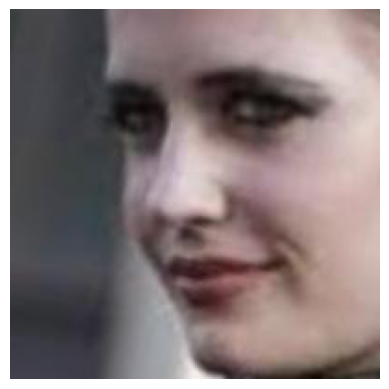

In [9]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

/tmp/ipykernel_22308/3234920688.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'])


<Axes: xlabel='age', ylabel='Density'>

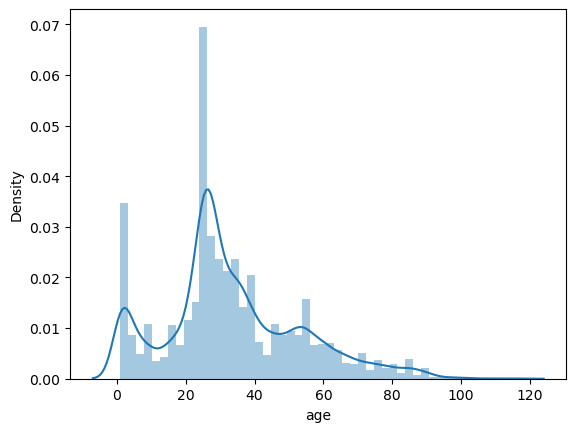

In [10]:
sns.distplot(df['age'])

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale = True)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features),128,128,1)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]/home/kanhaiya/anaconda3/lib/python3.11/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
/tmp/ipykernel_22308/869061983.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)
100%|██████████| 23708/23708 [00:51<00:00, 463.79it/s]


In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# X = X/255.0

In [15]:
y_age     = np.array(df['age'])
y_gender  = np.array(df['gender'])

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), input_shape = (128,128,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (3,3), input_shape = (128,128,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, kernel_size = (3,3), input_shape = (128,128,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256, kernel_size = (3,3), input_shape = (128,128,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))

model.add(Dropout(0.3))
model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid', name = 'gender_out'))
model.add(Dense(1, activation = 'relu', name = 'age_out'))

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');